In [622]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib.ticker import MaxNLocator
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, classification_report


In [623]:
df = pd.read_csv("abalone.data", header=None)
df.columns=['Sex','Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight','Rings']
print(df.head())

print(df.isna().sum())
print("Duplicated value=",df.duplicated().any())
df.describe()
# By reading the description of the dataset and calculating the weights we know that whole_weight is the sum of shucked_weight, viscera_weight,
#shell_weight and the weight of the amount of blood/water loss (but this is just an assumption). 
## We see an anomaly here. The minimum value of height is 0 which should not be the case. Therefore we should dig deeper to see the reason.


  Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  Viscera_weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell_weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64
Duplicated value= False


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [624]:
print(df['Height'].value_counts()[0])
print(df[df['Height']==0])
#Since all other variables seem to have a normal value we can assume that heigh=0 is not a measurement error and might just be a missing value. We will drop 
#these values
df.drop(df[df['Height']==0].index, inplace=True)
df.reset_index(drop=True, inplace=True)



2
     Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
1257   I   0.430      0.34     0.0         0.428          0.2065   
3996   I   0.315      0.23     0.0         0.134          0.0575   

      Viscera_weight  Shell_weight  Rings  
1257          0.0860        0.1150      8  
3996          0.0285        0.3505      6  


In [625]:
print(df.Sex.value_counts())
# Looking at the output we see a somewhat even distribution between male, female and infant 

M    1528
I    1340
F    1307
Name: Sex, dtype: int64


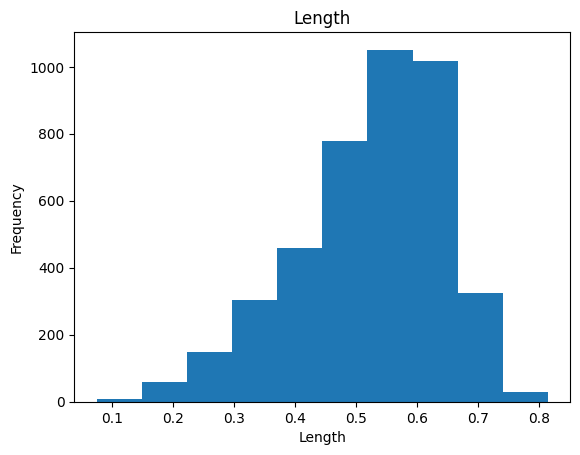

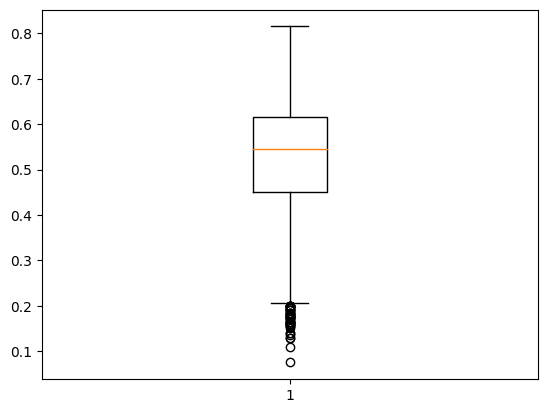

In [626]:
plt.hist(df["Length"])
plt.title("Length")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()
plt.boxplot(df["Length"])
plt.show()

# Looking at the histogram we can see that it is left skewed and majority of the abalone in the data have a length between 0.45 to 0.65 
# The box plot tells us that outliers exist below 0.2

In [627]:
#C
# H0: mu_m  = mu_f = mu_i
# H1: mu_m != mu_f !=mu_i
#where mu is the mean number of rings for each category of sex
df_m = df[df["Sex"]=='M']
df_f = df[df["Sex"]=='F']
df_i=df[df['Sex']=='I']

f_oneway(df_f["Rings"],df_i["Rings"],df_m["Rings"])

# Since the p-value is very small that is less than 0.05. Therefore there is enough evidence to reject H0. Which means that the mean of the 
# average number of rings for males, females and infants are different. Therefore, the statistical evidence provided by the ANOVA test 
# supports the idea of keeping the variable "sex" as a predictor of the variable "rings". The variable "sex" appears to have a significant effect 
# on the number of rings in the data set.

F_onewayResult(statistic=498.21337594887035, pvalue=9.389843756680774e-195)

In [628]:
# H0: mu_m  = mu_f 
# H1: mu_m != mu_f 
# where mu is the mean number of rings for each category of sex
df_m = df[df["Sex"]=='M']
df_f = df[df["Sex"]=='F']

f_oneway(df_m["Rings"],df_f["Rings"])

# After removing infant the p-value of 0.000244 suggests that there is a statistically significant difference in the mean number of rings between male and 
# female samples.Therefore, we can reject the null hypothesis that there is no difference in the mean number of rings between male and female
# samples, and conclude that there is a significant difference between the two groups.

F_onewayResult(statistic=13.49042693356504, pvalue=0.0002442194034404491)

The aim of this study is to predict the variable rings, lets see if there is evidence of multicollinearity?

In [629]:

y, X = dmatrices("Rings ~ C(Sex) + Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight",df, return_type="dataframe")

vif = pd.DataFrame()
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif["VIF Factor"]=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif["Feature"] = X.columns
vif.round(2)

#After performing a VIF we see that all variables except 'Sex' and 'Height' have multicollinearity issue and out of all of them 'whole_weight' has the highest 
#VIF value of 111.40. 

,VIF Factor,Feature
0,73.94,Intercept
1,1.98,C(Sex)[T.I]
2,1.40,C(Sex)[T.M]
3,40.91,Length
4,42.38,Diameter
5,3.60,Height
6,111.40,Whole_weight
7,28.81,Shucked_weight
8,17.49,Viscera_weight
9,21.85,Shell_weight


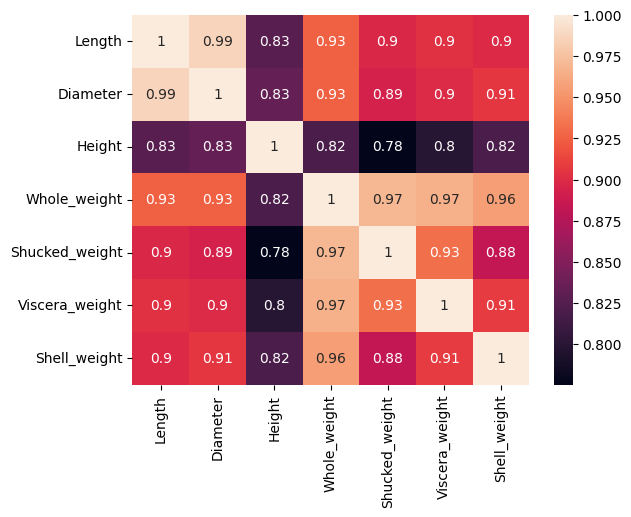

In [630]:
Xc = df[['Length','Diameter','Height','Whole_weight','Shucked_weight','Viscera_weight','Shell_weight']]
correlation_mat = Xc.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()
# Even the heat map shows us that most of the most of variables are highly correlated with eachother. We also observe very high correlation
# between Length and Diameter 
# We also see that the Whole_weight variable is highly correlated to other weight variables

 Fitting a linear model with the original variables, i.e., without any transformation on the predictors.

In [631]:
mod     = smf.ols("Rings ~ C(Sex) + Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight", data = df)
mod_res = mod.fit()
print(mod_res.summary())

#The r-squared and adj R-squared value are very close to each other that means it is a very well fitted model which means we have selected
# relevant features. The R-squared value of 0.538 tells us that 53.8% of the variation in Rings can be explained by the independent variables
# We also notice that the p value of Length is 0.810 which is greater than 0.05 we therefore fail to reject the null hypothesis and we could drop it.

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     538.6
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:52:53   Log-Likelihood:                -9199.9
No. Observations:                4175   AIC:                         1.842e+04
Df Residuals:                    4165   BIC:                         1.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9086      0.292     13.

Using principal components to transform the predictors and fit a linear regression model to check how good the model is as compared to the model fitted with original variables.

In [632]:
scaler = StandardScaler()
fitted = scaler.fit(Xc)
x      = fitted.transform(Xc) 

pca = PCA(n_components=Xc.shape[1])
pca_fit=pca.fit(x)
principalComponents = pca_fit.transform(x)
print(pca.explained_variance_ratio_) # % variability explained by the component
print("Var explained by PCs: ", np.cumsum(pca.explained_variance_ratio_))
PCs = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6','PC7'])
# print(pca.components_); # to see composition of PCs

DF = pd.concat([df, PCs], axis = 1)


[0.90818717 0.03977698 0.02390727 0.01613681 0.00923717 0.00181875
 0.00093585]
Var explained by PCs:  [0.90818717 0.94796414 0.97187142 0.98800823 0.99724539 0.99906415
 1.        ]


In [633]:
mod     = smf.ols("Rings ~ C(Sex)+ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 +PC7", data = DF)
mod_res = mod.fit()
print(mod_res.summary())
# When we use all the PCs to fit the model we solve the issue of multicolinearity and the r-squared, adj r-sq, AIC, BIC values are the same
# but since 4 PCs explain 98% of the variability we can therefore use 4 PCs

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     538.6
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:52:53   Log-Likelihood:                -9199.9
No. Observations:                4175   AIC:                         1.842e+04
Df Residuals:                    4165   BIC:                         1.848e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.1790      0.064    158.291      

In [634]:
mod     = smf.ols("Rings ~ C(Sex)+ PC1 + PC2 + PC3 + PC4", data = DF)
mod_res = mod.fit()
print(mod_res.summary())

# After using 4 PCs we see that the R-squared, and adj r-squared values decrease to 51.7% while the AIC and BIC values increase which means that the 
# 1st model will perform better 

                            OLS Regression Results                            
Dep. Variable:                  Rings   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     744.6
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        23:52:53   Log-Likelihood:                -9290.6
No. Observations:                4175   AIC:                         1.860e+04
Df Residuals:                    4168   BIC:                         1.864e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      10.2367      0.065    156.754      

In [635]:

pred =pd.DataFrame( {"Sex":['M'], "Length": [0.52], "Diameter": [0.41],"Height":[0.14],"Whole_weight":[0.83],"Shucked_weight":[0.36],"Viscera_weight":[0.18],"Shell_weight":[0.24]})
con_pred = pred.iloc[:,1:]

pred_std=fitted.transform(con_pred) 

principalComponents = pca_fit.transform(pred_std)
PCs = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7'])

DF = pd.concat([pred['Sex'], PCs], axis = 1)
#print(DF)
y=mod_res.predict(DF)
print(y)

#The model predicts the ring value of the abalone as 10.27 which means that the approximate age of the abalone given the above values would be 
# 10.27 + 1.5 which is 11.77 

0    10.277857
dtype: float64


Lets see if it is possible to predict the gender (just Female or Male) of an abalone given the continuous
predictors

In [636]:
newdf=df[df['Sex'] != 'I']
# print(newdf)
# newdf['Sex'].replace({'M': 0, 'F': 1}, inplace=True)
# newdf.Sex.value_counts()
X2 = newdf.iloc[:, 1:]
y2 = newdf[['Sex']]
print(newdf.Sex.value_counts())
response_count = newdf.groupby("Sex")["Sex"].count()

print("Percentage of Ms:", 100*response_count['M']/np.sum(response_count))
print("Percentage of Fs:", 100*response_count['F']/np.sum(response_count))

# Since there is not a massive difference between the distribution of males and females in the dataset therefore we don't need to balance our data 
# as it is fairly balanced 

M    1528
F    1307
Name: Sex, dtype: int64
Percentage of Ms: 53.89770723104056
Percentage of Fs: 46.10229276895944


In [637]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=0)


data_train = pd.concat([X_train, y_train], axis = 1)
mod     = sm.GLM.from_formula(" C(Sex) ~  Length + Diameter + Height + Whole_weight + Shucked_weight + Viscera_weight + Shell_weight + Rings", family = sm.families.Binomial(), data = data_train)
result = mod.fit()
print(result.summary())

print(result.null_deviance)
# The residual deviance shows how well the response is predicted by the model when the predictors are included.
print(result.deviance)

predictions = result.predict(X_test)
#print(predictions)
predictions_nominal = [ 'M' if x < 0.5 else 'F' for x in predictions]
#print(predictions_nominal)

cm = confusion_matrix(y_test, predictions_nominal)
print("Confusion matrix:\n ", cm)
#The diagonal elements of the confusion matrix indicate correct predictions,while the off-diagonals represent incorrect predictions

# Accuracy= 0.533 : Which states that the model is able to correctly predict the gender 53% of the time
print("Acuraccy: ", round(np.sum(np.diagonal(cm))/np.sum(cm),3))

# Sensitivity: 0.68 : The sensitivity of 0.68 means that the model is able to correctly identify 68% of the female abalones in the testing set
print("Sensitivity: ", round(cm[1,1]/np.sum(cm[1,:]),3))

# Specificity: 0.367 : The specificity of 0.367 means that the model is able to correctly identify 36.7% of the male abalones in the testing set.
print("Specificity: ", round(cm[0,0]/np.sum(cm[0,:]),3))


print(classification_report(y_test, 
                            predictions_nominal, 
                            digits = 3))




                     Generalized Linear Model Regression Results                      
Dep. Variable:     ['C(Sex)[F]', 'C(Sex)[M]']   No. Observations:                 1984
Model:                                    GLM   Df Residuals:                     1975
Model Family:                        Binomial   Df Model:                            8
Link Function:                          Logit   Scale:                          1.0000
Method:                                  IRLS   Log-Likelihood:                -1331.3
Date:                        Sun, 16 Apr 2023   Deviance:                       2662.7
Time:                                23:52:53   Pearson chi2:                 1.98e+03
No. Iterations:                             4   Pseudo R-squ. (CS):            0.03654
Covariance Type:                    nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

# Conclusion:

The results suggest that the model is not very effective at predicting the gender of abalone. Since the accuracy is only 53.3% it is just slightly better than random guessing, and the sensitivity and specificity are both relatively low. Therefore, it is not recommended to  use this model to predict the gender of abalones.
 



